# Setup

In [ ]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
import time
import matplotlib.image as mpimg
from IPython import display

If images have already been processed, augmented, and saved into an npz file, skip to 2. Model

# 1. Data Preparation
We'll first load our dataset from the google drive folder. We have limited the vessel trees to a maximum of 1000 segments due to restricted time.

## 1.1 Loading Dataset

In [ ]:
#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We have 3 folders with 1000 samples in each folder. Change the directory name to choose which value of n to train for a n-terminal segment vessel tree.

Number of files in folder: 594


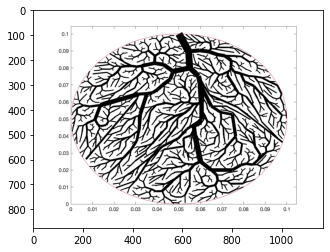

In [ ]:
#Define filepath
path = os.getcwd()+ '/drive/MyDrive/01_University/02_MEng/05_Year5/FYP/trainingdata/1000seg/'

#Create array of filenames of png files
filelist= [file for file in os.listdir(path) if file.endswith('.png')]
print('Number of files in folder:',len(filelist))

#Preview 1 file
img = mpimg.imread(str(path) + filelist[10])
imgplot = plt.imshow(img)
plt.show()

## 1.2 Preprocessing images
We will do the following:


*  Crop out axes
*  Resize to a 128 x 128 image

The file will then be saved into a 'compressed' folder. Rerunning this code automatically deletes current contents in the 'compressed' folder.



In [ ]:
#Import PIL.Image
from PIL import Image

#Define Image Size
IMGSIZE = 128
CROP_LEFT = 148
CROP_RIGHT = 80
CROP_TOP = 1020
CROP_BOTTOM = 779

#Define path to compressed folder
compressed_path = str(path) + 'compressed/'

#Remove existing files from compressed path
for file in os.listdir(compressed_path):
  os.remove(compressed_path + file)

n = 1

#Trim and resize images
for file in filelist:

  #open image
  img = Image.open(str(path) + file)
  wpercent = (IMGSIZE / float(img.size[0]))

  #Crop and resize image
  img = img.crop((CROP_LEFT,CROP_RIGHT,CROP_TOP,CROP_BOTTOM)) #crop
  img = img.resize((IMGSIZE, IMGSIZE), Image.ANTIALIAS) #resize

  #Save image
  img.save(str(compressed_path) + 'comp_' + file) #save

  #display progress
  print(str(n),'out of',len(filelist),'files processed..')
  n +=1

## 1.3 Data Augmentation
To dramatically increase our training dataset, we'll slightly modify each file in the following ways:

*   Horizontal mirroring
*   Clockwise rotation by 15 degrees
*   Anticlockwise rotation by 15 degrees

This will increase our dataset by **6 times**

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
from scipy import ndimage

#generate a list of all files in 'compressed' folder
compressedlist = [file for file in os.listdir(compressed_path) if file.endswith('.png')]

#Define path to augmented folder
augmented_path = str(compressed_path) + 'Augmented/'

#Remove existing files from augmented path
for file in os.listdir(augmented_path):
  os.remove(augmented_path + file)

#Initialise counter
n = 1

#Loop through each file in 'compressed' folder
for file in compressedlist:

  #Read image
  image = cv2.imread(compressed_path + file)

  #Invert image for ease of processing
  image = np.invert(image)

  #Flip Horizontally    
  flippedimage = cv2.flip(image,1)
  flippedimage = Image.fromarray(flippedimage)

  #Rotate 15 deg clockwise
  clockrotatedimage = ndimage.rotate(image,15)
  clockrotatedimage = clockrotatedimage[17:145,17:145]
  clockrotatedimage = Image.fromarray(clockrotatedimage)

  #Rotate 15 deg anticlockwise
  anticlockrotatedimage = ndimage.rotate(image,-15)
  anticlockrotatedimage = anticlockrotatedimage[17:145,17:145]
  anticlockrotatedimage = Image.fromarray(anticlockrotatedimage)

  #Flip + Rotate 15 deg clockwise
  flippedclockrotatedimage = ndimage.rotate(flippedimage,15)
  flippedclockrotatedimage = flippedclockrotatedimage[17:145,17:145]
  flippedclockrotatedimage = Image.fromarray(flippedclockrotatedimage)

  #Flip + Rotate 15 deg anticlockwise
  flippedanticlockrotatedimage = ndimage.rotate(flippedimage,-15)
  flippedanticlockrotatedimage = flippedanticlockrotatedimage[17:145,17:145]
  flippedanticlockrotatedimage = Image.fromarray(flippedanticlockrotatedimage)
  image = Image.fromarray(image)

  #Save all augmented images
  image.save(str(augmented_path) + file)
  flippedimage.save(str(augmented_path) + 'MIR_' + file)
  clockrotatedimage.save(str(augmented_path) + 'clockrot_' + file)
  anticlockrotatedimage.save(str(augmented_path) + 'aclockrot_' + file)
  flippedclockrotatedimage.save(str(augmented_path) + 'MIR_clockrot_' + file)
  flippedanticlockrotatedimage.save(str(augmented_path) + 'MIR_aclockrot_' + file)

  #Display progress
  print(str(n),'out of',len(compressedlist),'files processed..')
  n += 1

## 1.4 Compiling training dataset
The dataset is merged into one npz file

In [ ]:
from keras.preprocessing import image

def gen_training(file_path,filenames):
#function merges all images into one numpy array

  #Initialise empty numpy array of size nx128x128
  allArrays = np.empty([0,128,128])

  i = 1
  #Loop through all files
  for file in filenames:
    
    #Load image
    img = image.load_img(str(file_path) + file,color_mode = "grayscale")

    #Convert image to numpy array
    input_arr = image.img_to_array(img) #Convert to numpy array
    input_arr = np.array([input_arr])  # Convert single image to a batch.
    input_arr = np.squeeze(input_arr) #Squeeze numpy array
    allArrays = np.append(allArrays,[input_arr], axis = 0)  #append to allArrays

    #Display progress
    print (str(i) + ' out of ' + str(len(filenames)))
    i+=1
  return allArrays

#Generate list of all augmented images
augmentedlist = [file for file in os.listdir(augmented_path) if file.endswith('.png')]

#Convert all files in augmented list into numpy array and concatenate
training_data = gen_training(augmented_path,augmentedlist)

#Print overall size of training dataset
print(training_data.shape)

#Save as an npz file 
np.savez(os.getcwd() + '/drive/MyDrive/01_University/02_MEng/05_Year5/FYP/trainingdata/1000_seg_trainingdata.npz',training_data)

# 2. Model
Here, we define the sub models (generator and discriminator) to be trained.


## 2.1 Load training data set

In [ ]:
#Define filepath to be loaded
load_path = '/drive/MyDrive/01_University/02_MEng/05_Year5/FYP/trainingdata/100_seg_trainingdata.npz'

#Load npz file
train_images = np.load(os.getcwd() + load_path)

#Unzip file and normalise images to [-1,1] for easier convergence in ML model
train_images = train_images['arr_0']
train_images = train_images.reshape(train_images.shape[0], 128, 128,1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

#Print size of training dataset
print(train_images.shape)

(3300, 128, 128, 1)


In [ ]:
#Define buffer and batch size, used for batch shuffling
BUFFER_SIZE = 60000 #affects the degree of randomness in shuffling (the higher = more shuffling)
BATCH_SIZE = 256  #number of samples that will be propagated through the network

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## 2.2 The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 128x128x1. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 128, 128, 1)

    return model

Use the (as yet untrained) generator to create an image.

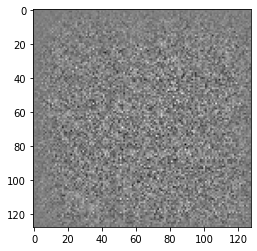

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

## 2.3 The Discriminator

The discriminator is a CNN-based image classifier.

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[128, 128, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.0002686]], shape=(1, 1), dtype=float32)


## 2.4 Define the loss and optimizers

Define loss functions and optimizers for both models.


In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### 2.4.1 Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### 2.4.2 Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since we will train two networks separately.

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# 3. Training

## 3.1 Define the training loop


In [ ]:
EPOCHS = 2000 # number of passes of the entire dataset the model passes
noise_dim = 100 # specifies the length of the random noise vector z
num_examples_to_generate = 4  #number of example images to generate

seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 25 epochs
    if (epoch + 1) % 25 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
      display.clear_output(wait=True)
      saveimagecheckpoint(generator,
                             epoch + 1,
                             seed)
      
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

**Generate and save images**


In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(2, 2, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
def saveimagecheckpoint(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(20,20))

  for i in range(predictions.shape[0]):
      plt.subplot(2, 2, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  images_dir = os.getcwd() + '/drive/MyDrive/01_University/02_MEng/05_Year5/FYP/trainingdata'
  plt.savefig(f'{images_dir}/100_seg_epoch_{epoch}.png')
  plt.show()

## 3.2 Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

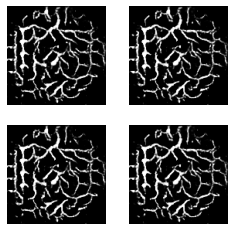

In [ ]:
train(train_dataset, EPOCHS)